## Visualizing network availability

The logfile is generated in the local home server. A small Perl script is continously running and tests if it has an access to the internet. The whole motivation of this small project was that recently we were experience frequent gaps in the internet service, so I decided to collect evidence for a complaint.

In [74]:
from datetime import datetime
print datetime.now()

2016-02-06 00:22:58.449141


During the observed period (2016.Feb.02-06), we experienced 91 outages in the internet service lasting altogether
162.0 minutes. The average outage lasted for 106.81 seconds while the median length of the outages was 92.0.


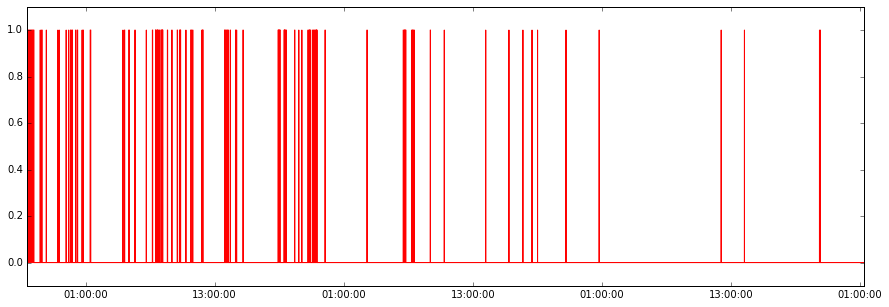

In [75]:
import urllib2
from smb.SMBHandler import SMBHandler
import pandas as pd
import pytz
import matplotlib.pyplot as plt
import numpy as np

# Reading the logfile into a dataframe:
logfile = "smb://192.168.1.110/Backup/Dani/home/miccalogs/2016.02.02_pingtest.lst"
director = urllib2.build_opener(SMBHandler)
fh = director.open(logfile)
df = pd.read_csv(fh, sep="\t", )

# Parsing datetime object and set timezome to GMT from PST 
# (Our NAS thinks we are still in California :)
dates = [datetime.strptime(x, '%Y-%m-%d_%H:%M:%S') for x in df.DateTime]
df["dates"] = dates
df["Exit_code"] = df.Ping_exit_code / 256 # perl multiplies all exit codes by 256, so it has to be back transformed
# Exit code 0 - Package successfully sent, and response received.
# Exit code 1 - Package sending was failed.
# Exit code 2 - Package was successfully sent, but no response received.

ts = pd.Series(df.Exit_code.tolist(), index=df.dates)
ts = ts.tz_localize('US/Alaska')
ts = ts.tz_convert('Europe/London')

# Now let's summarize the outages:
# Let's summarize the service outage:
lower = 'x'
upper = ''
missing_net = {}
for index in range(len(df)):
    if df.Exit_code[index] == 1:
        if lower == 'x':
            lower = df.dates[index]
    else:
        if not lower == 'x':
            upper = df.dates[index-1]
            missing_net[lower] = upper - lower
            lower = 'x'

number = len(missing_net)
missing = 0;
missing_hist = []
for trange in missing_net.values():
    missing += trange.seconds
    missing_hist.append(trange.seconds)

mean = np.mean(missing_hist)
median = np.median(missing_hist)

# Printing out record:
print '''During the observed period (%s-%s), we experienced %s outages in the internet service lasting altogether
%s minutes. The average outage lasted for %s seconds while the median length of the outages was %s.''' %(
    ts.index[0].strftime("%Y.%h.%d"), ts.index[-1].strftime("%d"), len(missing_hist), round(float(missing)/60, 2),
    np.round(mean,2), np.round(median,2))

# Plot time series, and save figure.
fig = plt.figure(figsize=(15,5))
plt.ylim([-0.1, 1.1])
plt.fill_between(ts.index, ts, np.zeros(len(ts)), where=None, color = 'red', 
                 facecolor='red', interpolate=False, step=None, hold=None, data=None)

# Generate filename for the plot:
filename = '%s_%s.png' %( ts.index[0].strftime("%Y.%m.%d_%H.%M"), ts.index[-1].strftime("%Y.%m.%d_%H.%M"))
plt.savefig(filename)